In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [17]:
(training_set, validation_set), metadata = tfds.load('tf_flowers', 
                                                     split=tfds.Split.TRAIN.subsplit([70, 30]), 
                                                     as_supervised=True, with_info=True) 
classes = np.array(metadata.features['label'].names)

In [18]:
# Size of training and test sets
train_size = 0
val_size = 0
for example in training_set:
    train_size += 1
for example in validation_set:
    val_size += 1
print("Number of training examples: {}".format(train_size))
print("Number of training examples: {}".format(val_size))

IMG_SIZE = 224
# Normalise data
def formatting(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))/255
    return images, labels

training_set = training_set.map(formatting)
validation_set = validation_set.map(formatting)

Number of training examples: 2590
Number of training examples: 1080


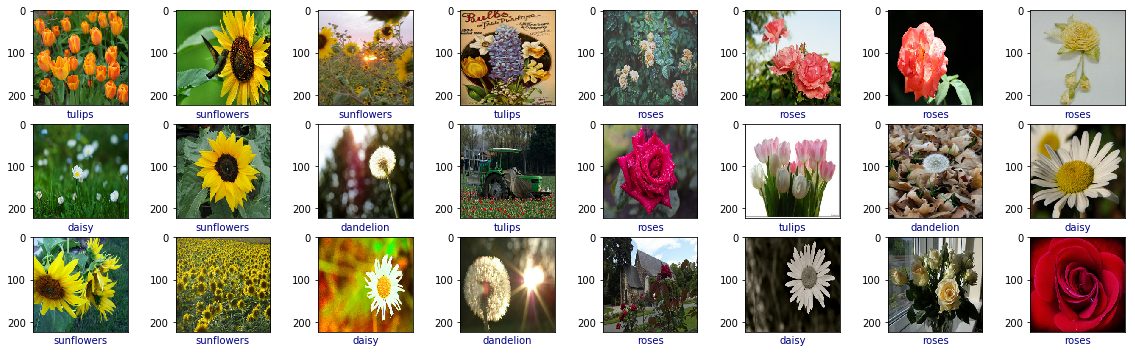

In [4]:
# Print example and its class
plt.figure(figsize=(20,8))
i = 0
for (image, label) in training_set.take(24):
    plt.subplot(4,8,i+1)
    plt.imshow(image)
    plt.xlabel(classes[label.numpy()], color='navy')
    plt.xticks([])
    #plt.yticks([])
    i += 1
    if 23 < i: break
plt.show()

In [5]:
import tensorflow_hub as hub
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMG_SIZE, IMG_SIZE, 3))
])
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

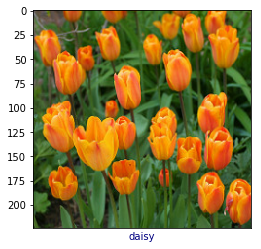

In [6]:
for (image,label)  in training_set.take(1):
    result = model.predict(image[np.newaxis,...])
    plt.imshow(image)
    plt.xticks([])
    plt.xlabel(imagenet_labels[np.argmax(result)], color='navy')
    #break

In [8]:
# Fetch pretrained feature extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SIZE, IMG_SIZE,3))
feature_extractor.trainable = False

In [9]:
# Attach classifier head to pretrained MobileNET V2
model_t = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(5, activation = 'softmax')
])
# 
model_t.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
# Shuffling and splitting of training set 
BATCH_SIZE = 32
training_set = training_set.repeat().shuffle(train_size).batch(BATCH_SIZE)
validation_set = validation_set.batch(BATCH_SIZE)

In [13]:
# Training
history = model_t.fit(training_set,
                    epochs=6,
                    validation_data=validation_set,
                    steps_per_epoch=np.ceil(train_size/BATCH_SIZE))

Epoch 1/6
81/81 [==============================] - 193s 2s/step - loss: 0.3446 - accuracy: 0.8947 - val_loss: 0.3637 - val_accuracy: 0.8731
Epoch 2/6
81/81 [==============================] - 185s 2s/step - loss: 0.2984 - accuracy: 0.9039 - val_loss: 0.3414 - val_accuracy: 0.8861
Epoch 3/6
81/81 [==============================] - 187s 2s/step - loss: 0.2496 - accuracy: 0.9236 - val_loss: 0.3156 - val_accuracy: 0.8954
Epoch 4/6
81/81 [==============================] - 196s 2s/step - loss: 0.1997 - accuracy: 0.9468 - val_loss: 0.3036 - val_accuracy: 0.8981
Epoch 5/6
81/81 [==============================] - 200s 2s/step - loss: 0.1784 - accuracy: 0.9545 - val_loss: 0.2939 - val_accuracy: 0.9009
Epoch 6/6
81/81 [==============================] - 199s 2s/step - loss: 0.1572 - accuracy: 0.9587 - val_loss: 0.2872 - val_accuracy: 0.8981


Text(0.5, 1.0, 'Training and Validation Accuracy')

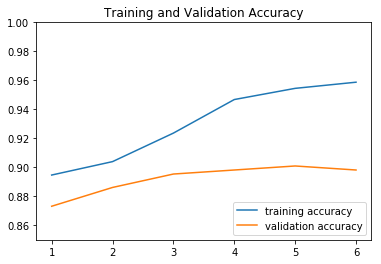

In [14]:
plt.plot(range(1,7), history.history['accuracy'], label='training accuracy')
plt.plot(range(1,7), history.history['val_accuracy'], label='validation accuracy')
plt.ylim(0.85,1.0)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

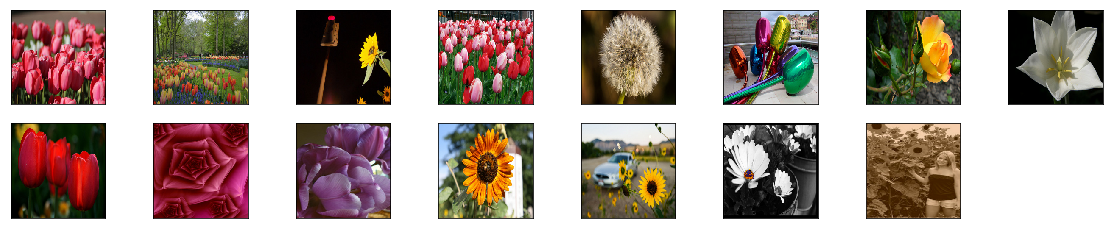

In [21]:
# Print example and its predicted class
plt.figure(figsize=(20,8))
i = 0
for (image,label) in validation_set.take(15):
    plt.subplot(4,8,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel((classes[label.numpy()], classes[model_t.predict([[image]]).argmax()]), color='white')
    i += 1
    if 15 < i: break
plt.show()